Take in athlete PR
Convert to percentage of world record
Create other expected perfomances for different races
Plot on graph
Take GAP of Segment
Plot gap on graph, see if over or under curve

In [76]:
import datetime
WR_800 = datetime.timedelta(minutes=1,seconds=40)
WR_MILE = datetime.timedelta(minutes=3,seconds=43)
WR_2K = datetime.timedelta(minutes=4,seconds=44) 
WR_3K = datetime.timedelta(minutes=7,seconds=20)
WR_5K = datetime.timedelta(minutes=12,seconds=35)
WR_10K = datetime.timedelta(minutes=26,seconds=24)
WR_10M = datetime.timedelta(minutes=44,seconds=24)
WR_MARATHON = datetime.timedelta(hours=2,minutes=1,seconds=39)

def pr_to_wr_percentage(athlete_pr:datetime.time):
    # assume 5k for now
    # TODO allow for other PR entry
    percentage_of_wr =  WR_5K.total_seconds() / athlete_pr.total_seconds()
    return percentage_of_wr

def get_equivalent_time_all_records(wr_percentage):
    rigels_constant = 1.06 # helps with accuracy
    t_0 = 0
    t_800 = WR_800.total_seconds() + (WR_800.total_seconds() * (1-wr_percentage)) * rigels_constant
    t_mile = WR_MILE.total_seconds() + (WR_MILE.total_seconds() * (1-wr_percentage))* rigels_constant
    t_2k = WR_2K.total_seconds() + (WR_2K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_3k = WR_3K.total_seconds() + (WR_3K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_5k = WR_5K.total_seconds() + (WR_5K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_10k = WR_10K.total_seconds() + (WR_10K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_10m = WR_10M.total_seconds() + (WR_10M.total_seconds() * (1-wr_percentage))* rigels_constant
    t_mara = WR_MARATHON.total_seconds() + (WR_MARATHON.total_seconds() * (1-wr_percentage))* rigels_constant
    return t_0,t_800,t_mile,t_2k,t_3k,t_5k,t_10k,t_10m,t_mara


In [79]:
pr = datetime.timedelta(minutes=14,seconds=46)
percentage = pr_to_wr_percentage(pr)

In [80]:
print(get_equivalent_time_all_records(percentage))

(0, 115.6726862302483, 257.95009029345374, 328.5104288939052, 508.95981941309253, 873.3287810383747, 1832.2553498871332, 3081.520361173815, 8442.949367945825)


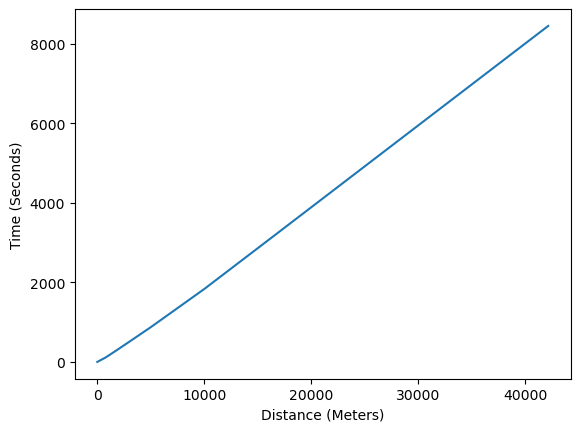

In [134]:
from matplotlib import pyplot as plt
distances = [0,800,1609,2000,3000,5000,10000,16093.4,42164.81]
def graph_distance_v_time(equivalent_event_times):
    meters = distances
    time = equivalent_event_times
    plt.xlabel("Distance (Meters)")
    plt.ylabel("Time (Seconds)")
    plt.plot(meters,time)
    plt.show()
    return meters,time
    

plot_data = graph_distance_v_time(get_equivalent_time_all_records(percentage))


In [83]:
# Gap is 10s per 44ft per 1609.34m
# So GAP pace change = -10 * ((elevation gain/drop/#miles) * (#miles)/44) 
# In meteres = -10 * ((elevation gain/drop/(distance/1609.44)) * ((distance/1609.4)/44) 
# Break down a run into 10m stretches
# GAP is 10/160.09 seconds per 44/160.09 ft gain/drop per 10m
# So for a 10m run in 

In [123]:
def calc_GAP(distance,time,elevation_gain):
    # presume distance in meterss and elevation_gain in meters
    meters_to_miles_conversion = 1/1609.44
    ft_to_meters_conversion = 1/3.281
    pace = time/distance
    GAP_addition = -10 * (elevation_gain/(distance*meters_to_miles_conversion)) * ((distance*meters_to_miles_conversion)/(44*ft_to_meters_conversion)) 
    GAP = pace + GAP_addition/1609.44
    return GAP



In [128]:
# Need to determine whether a point is above or below graph line
def graph_segment_on_athlete_curve(plot_data,segment_data,segment_name):
    plt.xlabel("Distance (Meters)")
    plt.ylabel("Time (Seconds)")
    plot_x_nearest_to_segment = min(plot_data[0], key=lambda x:abs(x-segment_data[0]))
    plot_y_nearest_to_segment = min(plot_data[1], key=lambda x:abs(x-segment_data[1]))

    # plotting a random point for comparison
    # TODO find a way to check if above or below line instantly
    plt.axis([segment_data[0]-100,segment_data[0]+100,
    min(plot_x_nearest_to_segment,segment_data[1]-100),max(plot_y_nearest_to_segment,segment_data[1]+100)])
    plt.scatter([segment_data[0]],[segment_data[1]],color="red",label=f"{segment_name} Segment")
    plt.plot(plot_data[0],plot_data[1],label="Athlete")
    plt.legend()
    plt.show()

def calc_above_or_below_plt_line(plot_data,segment_data):
    # Calculate cross product
    xA = segment_data[0]
    yA = segment_data[1]
    x1 = 0
    x2 = 0
    y1 = 0
    y2 = 0
    for distance_index in range(len(plot_data[0])):
        if plot_data[0][distance_index] > xA:
            x1 = plot_data[0][distance_index]
            y1 = plot_data[1][distance_index]
            x2 = plot_data[0][distance_index-1]
            y2 = plot_data[1][distance_index-1]
            break
    v1 = (x2-x1, y2-y1)   
    v2 = (x2-xA, y2-yA)   
    cross_product = v1[0]*v2[1] - v1[1]*v2[0] 
    if cross_product > 0:
        print('Athlete is faster than segment')
    elif cross_product < 0:
        print('Athlete is slower than segment')
    else:
        print('Athlete is exactly as fast as segment')
        


In [145]:
import json
import datetime
def get_segment_data_from_file(filename,segment_id):
        with open(filename,"r") as file:
                segment_data_dict = json.load(file)
        return segment_data_dict[segment_id]

def convert_segment_data_to_floats(segment_data:list):
        meters = float(segment_data[0][:-2])*1000
        hours_10s  = int(segment_data[1][-8]) if len(segment_data[1]) > 7 else 0
        hours_1s  = int(segment_data[1][-7]) if len(segment_data[1]) > 6 else 0
        mins_10s =  int(segment_data[1][-5]) if len(segment_data[1]) > 4 else 0
        mins_1s  = int(segment_data[1][-4]) if len(segment_data[1]) > 3 else 0
        seconds_10s = int(segment_data[1][-2]) if len(segment_data[1]) > 1 else 0
        seconds_1s = int(segment_data[1][-1]) if len(segment_data[1]) > 0 else 0
        total_seconds = (36000*hours_10s)+(3600*hours_1s)+(600*mins_10s)+(60*mins_1s)+ (10*seconds_10s) + seconds_1s
        evelation_gain = int(segment_data[2][:-1])
        return meters,total_seconds,evelation_gain


In [146]:

segment_data = get_segment_data_from_file("data/scraped_segment_data.json","1439652")
print(segment_data)
distance,time,gain = convert_segment_data_to_floats(segment_data)
print(distance,time,gain)
grade_adjusted_time = calc_GAP(distance,time,gain) * distance
print(grade_adjusted_time)




['1.88km', '5:40', '4m']
1880.0 340 4
336.5158519281693


Athlete is slower than segment


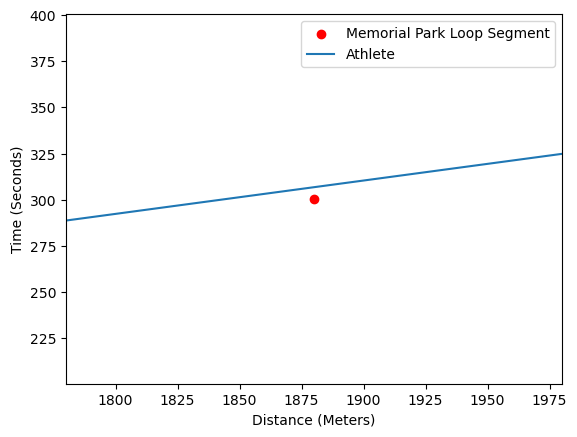

In [129]:
segment_data = (distance,grade_adjusted_time) # distance,time
calc_above_or_below_plt_line(plot_data,segment_data)
graph_segment_on_athlete_curve(plot_data,segment_data,"Memorial Park Loop")

# Wrapping it all up

In [142]:
# pr given as timedelta object
def get_athlete_vs_segment(athlete_5k_pr,segment_id,segment_name):
    #pr = datetime.timedelta(minutes=14,seconds=46)
    percentage = pr_to_wr_percentage(pr)
    equivalent_times = get_equivalent_time_all_records(percentage)
    plot_distances = [0,800,1609,2000,3000,5000,10000,16093.4,42164.81]
    segment_data = get_segment_data_from_file("data/scraped_segment_data.json",segment_id)
    print(segment_data)
    distance,time,gain = convert_segment_data_to_floats(segment_data)
    grade_adjusted_time = calc_GAP(distance,time,gain) * distance
    print(time)
    print(grade_adjusted_time)
    segment_data = (distance,grade_adjusted_time) # distance,time
    calc_above_or_below_plt_line((distances,equivalent_times),segment_data)
    graph_segment_on_athlete_curve((distances,equivalent_times),segment_data,segment_name)
    

['4.96km', '15:16', '38m']
916
828.6739057741146
Athlete is slower than segment


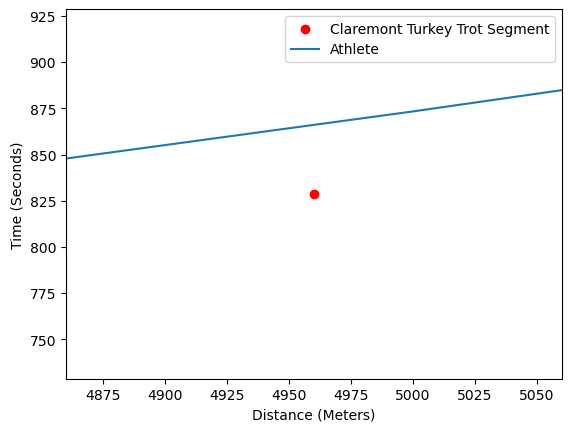

In [148]:
pr = datetime.timedelta(minutes=14,seconds=46)
segment_id = "6105319"
segment_name = "Claremont Turkey Trot"
get_athlete_vs_segment(pr,segment_id,segment_name)


# Conclusions:
Looks like this GAP formula is pretty agressive. I think it probably works better for larger elevations, but it seems unfair to drop 30s per mile on a 3 mile run with 132ft gain. I think I'll need to find a way to find tune this model

# GAP Equation 2.0
This equation says that for every 1% grade in elevation, there is a 12-15s decrease per mile
In km's that 7.46-9.32s

In [149]:
# TODO Am i accounting for negative grade
def get_GAP_2(distance,time,elevation_gain):
    grade = (elevation_gain/distance) * 100
    grade_adjusted_time_low = ((grade * 7.46/1000) * distance) + time
    grade_adjusted_time_high = ((grade * 9.32/1000) * distance) + time
    return grade_adjusted_time_low,grade_adjusted_time_high